In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

import skimage
from skimage import io
from skimage.transform import resize

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import seaborn as sn

In [2]:
train_dir = os.path.join(sys.path[0], 'train/')
test_dir = os.path.join(sys.path[0], 'test/')

In [3]:
def readHieroglyphData(data_dir):
    images = []
    targets = []
    for hier in os.listdir(data_dir):
        if not os.path.isdir(os.path.join(data_dir, hier)):
            continue
        for img in os.listdir(os.path.join(data_dir, hier)):
            targets.append(hier)
            images.append(np.asarray(io.imread(os.path.join(data_dir, hier, img))))
    return images, targets

In [4]:
def resizeImageData(data, image_size):
    resize_func = lambda img: resize(img, (image_size, image_size), anti_aliasing=True)
    resized_data = list(map(resize_func, data))
    return resized_data

In [5]:
images_train, targets_train = readHieroglyphData(train_dir)

In [6]:
images_test, targets_test = readHieroglyphData(test_dir)

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(targets_train)
print(list(le.classes_))

['D2', 'D21', 'D36', 'D4', 'D46', 'D58', 'E23', 'E34', 'F31', 'F35', 'G1', 'G17', 'G43', 'I10', 'I9', 'M17', 'M23', 'N35', 'O1', 'O34', 'O4', 'O49', 'Q1', 'Q3', 'R4', 'R8', 'S29', 'S34', 'U7', 'V13', 'V28', 'V30', 'V31', 'W11', 'W24', 'X1', 'X8', 'Y1', 'Y5', 'Z1']


In [8]:
labels_train = le.transform(targets_train)
labels_test = le.transform(targets_test)

In [9]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

num_labels = len(le.classes_)
x_train = np.expand_dims(images_train, -1) 
x_test = np.expand_dims(images_test, -1)

y_train = to_categorical(labels_train, num_labels)
y_test = to_categorical(labels_test, num_labels)

x_train.shape

(2467, 75, 50, 1)

In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

image_shape = (75, 50, 3)
base_model = ResNet50(include_top=False, input_shape=image_shape, pooling = 'avg', weights = 'imagenet')

modelResNet = models.Sequential()
modelResNet.add(base_model)

modelResNet.add(layers.Dense(256, activation="relu"))
modelResNet.add(layers.Dropout(0.3))
modelResNet.add(layers.Dense(128, activation="relu"))
modelResNet.add(layers.Dropout(0.3))

modelResNet.add(layers.Dense(num_labels, activation = 'softmax'))

In [11]:
modelResNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                5160      
Total params: 24,150,312
Trainable params: 24,097,192
Non-trainable params: 53,120
_______________________________________

In [12]:
#https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images
train_images_rgb = np.repeat(np.array(images_train)[..., np.newaxis], 3, -1)
test_images_rgb = np.repeat(np.array(images_test)[..., np.newaxis], 3, -1)

In [13]:
train_images_rgb = tf.keras.applications.resnet.preprocess_input(train_images_rgb)
test_images_rgb = tf.keras.applications.resnet.preprocess_input(test_images_rgb)

In [14]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [15]:
modelResNet.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

train_history = modelResNet.fit(
    train_images_rgb, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(test_images_rgb, y_test))

Epoch 1/20
78/78 [==============================] - 21s 182ms/step - loss: 1.6119 - accuracy: 0.6595 - val_loss: 125.1384 - val_accuracy: 0.0394
Epoch 2/20
78/78 [==============================] - 12s 155ms/step - loss: 0.7946 - accuracy: 0.8200 - val_loss: 1.4575 - val_accuracy: 0.7921
Epoch 3/20
78/78 [==============================] - 12s 155ms/step - loss: 0.4024 - accuracy: 0.8942 - val_loss: 0.3208 - val_accuracy: 0.9228
Epoch 4/20
78/78 [==============================] - 12s 154ms/step - loss: 0.3349 - accuracy: 0.9266 - val_loss: 0.4169 - val_accuracy: 0.8724
Epoch 5/20
78/78 [==============================] - 12s 159ms/step - loss: 0.3393 - accuracy: 0.9112 - val_loss: 0.2537 - val_accuracy: 0.9276
Epoch 6/20
78/78 [==============================] - 12s 154ms/step - loss: 0.1875 - accuracy: 0.9550 - val_loss: 0.3291 - val_accuracy: 0.9134
Epoch 7/20
78/78 [==============================] - 12s 156ms/step - loss: 0.1712 - accuracy: 0.9570 - val_loss: 0.3388 - val_accuracy: 0.94

In [16]:
scores_resnet = modelResNet.evaluate(test_images_rgb, y_test)

print("Loss: " + str(scores_resnet[0]))
print("Accuracy: " + str(scores_resnet[1]))

20/20 [==============================] - 1s 37ms/step - loss: 0.1474 - accuracy: 0.9654
Loss: 0.1473819613456726
Accuracy: 0.965354323387146


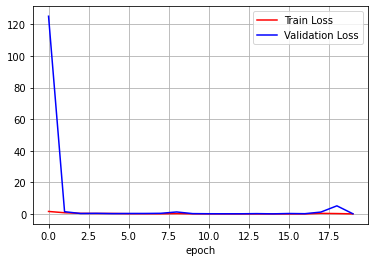

In [17]:
plt.plot(train_history.history['loss'], color='r', label='Train Loss')
plt.plot(train_history.history['val_loss'], color='b', label='Validation Loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

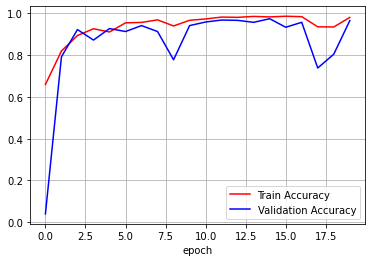

In [18]:
plt.plot(train_history.history['accuracy'], color='r', label='Train Accuracy')
plt.plot(train_history.history['val_accuracy'], color='b', label='Validation Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

[Text(0.5, 123.0, 'Predicted label'), Text(168.0, 0.5, 'True label')]

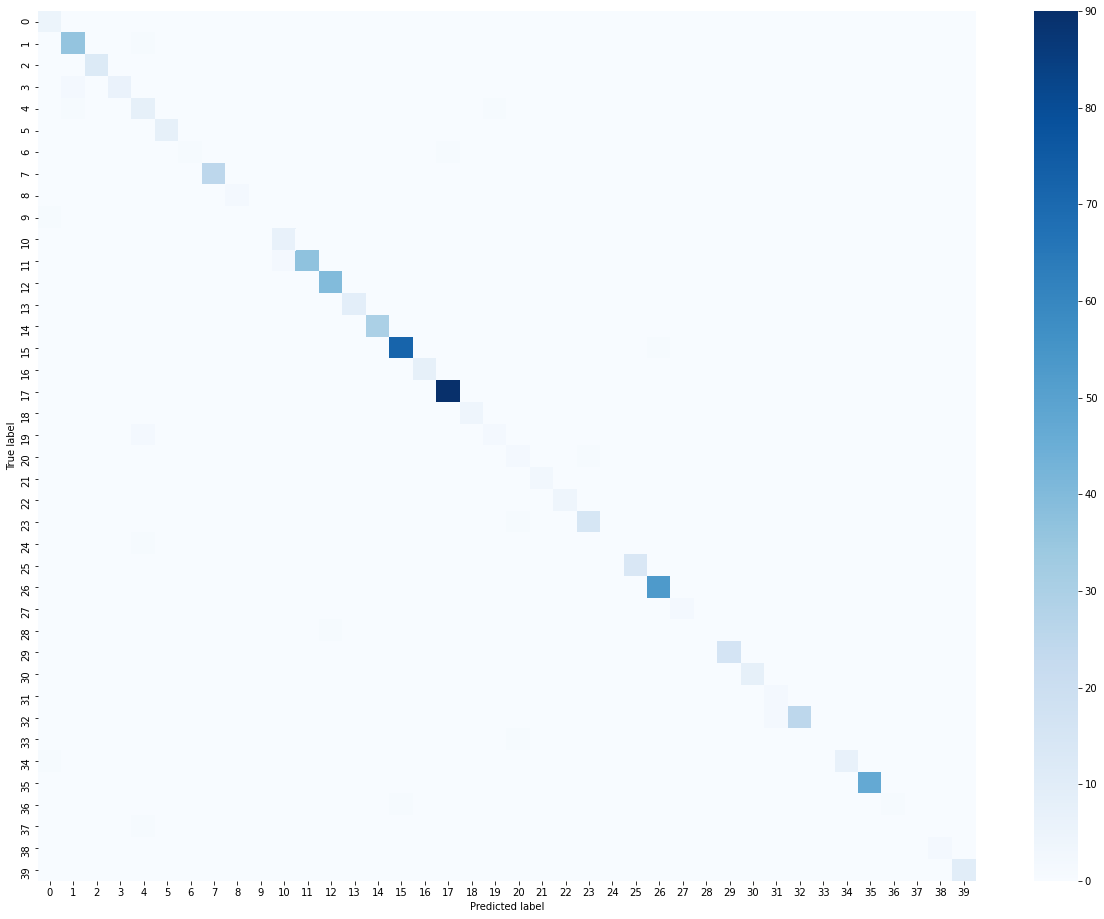

In [19]:
y_pred = [np.argmax(i) for i in modelResNet.predict(test_images_rgb)]
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm)

plt.figure(figsize = (21,16))
ax = sn.heatmap(df_cm, cmap="Blues")
ax.set(xlabel='Predicted label', ylabel='True label')